# 一步一步实现CNN

<img src="my_files/cnn_1.png" style="width:600px;height:600px;">
<img src="my_files/cnn_2.png" style="width:750px;height:600px;">

## 1 packages

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'


%load_ext autoreload
%autoreload 2

np.random.seed(1)


/Users/pengju/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 3 卷积层

### 3.1 zero-padding

In [3]:
def zero_pad(X,pad):
    """
    zero padding    

    Parameters
    ----------
    X : (m,n_H,n_W,n_C)    
    pad : int

    Returns
    -------
    X_pad : 
     
    """
    
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant')
    return X_pad
    

x.shape=(4, 3, 3, 2)
x_pad.shape=(4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


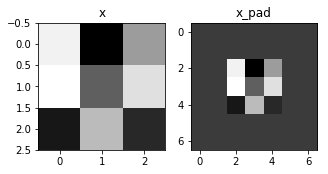

In [4]:
np.random.seed(1)
x=np.random.randn(4,3,3,2)
x_pad=zero_pad(x,2)
print("x.shape={}".format(x.shape))
print("x_pad.shape={}".format(x_pad.shape))

print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])


fig,axarr=plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])


### 3.2 单步卷积

In [5]:
def conv_single_step(a_slice_prev,W,b):
    """
    单步卷积计算
    

    Parameters
    ----------
    a_slice_prev : f x f x n_c_prev
    W : f x f x n_c_prev
    b : 1 x 1 x    

    Returns
    -------
    Z : scalar 
     
    """
    s=np.multiply(W,a_slice_prev)
    Z=np.sum(s)

    Z=Z+float(b)
    return Z
    
    

In [6]:
np.random.seed(1)
a_slice_prev=np.random.randn(4,4,3)
W=np.random.randn(4,4,3)
b=np.random.randn(1,1,1)
Z=conv_single_step(a_slice_prev,W,b)
print("Z={}".format(Z))

Z=-6.999089450680221


### 3.3 卷积整体计算
- 核心就是循环计算卷积结果
- 发现错误： `A_prev_pad[i,j*f_H:(j+1)*f_H,k*f_W:(k+1)*f_W,:]` 应改为 `A_prev_pad[i,j*stride:(j*stride+f_H),k*stride:(k*stride+f_W),:]`,因为 f=stride，所以没有发现这个错误

In [80]:
def conv_forward(A_prev,W,b,hparameters):
    """
    卷积正向传播
    

    Parameters
    ----------
     A_prev: (m,n_H_prev,n_W_prev,n_C_prev)     
     W: (f_H,f_W,n_C_prev,n_C)
     b:(1,1,1,n_C) 
     hparameters: dict pad stride      

    Returns
    -------
    Z:(m,n_H,n_W,n_C)
    cache_conv:A_prev,W,b     
    """
    m,n_H_prev,n_W_prev,n_C_prev=A_prev.shape
    f_H,f_W,_,n_C=W.shape
    pad=hparameters['pad']
    stride=hparameters['stride']

    n_H=(n_H_prev+2*pad-f_H)//stride+1
    n_W=(n_W_prev+2*pad-f_W)//stride+1

    Z=np.zeros(shape=(m,n_H,n_W,n_C))

    A_prev_pad=zero_pad(A_prev,pad)

    for i in range(m):
        for j in range(n_H):
            for k in range(n_W):
                
                a_prev_slice=A_prev_pad[i,j*stride:(j*stride+f_H),k*stride:(k*stride+f_W),:]
                for l in range(n_C):
                    Z[i,j,k,l]=conv_single_step(a_prev_slice,W[:,:,:,l],b[:,:,:,l])
    assert(Z.shape==(m,n_H,n_W,n_C))
    cache=(A_prev,W,b,hparameters)
    return Z,cache

In [81]:
np.random.seed(1)
A_prev=np.random.randn(10,4,4,3)
W=np.random.randn(2,2,3,8)
b=np.random.randn(1,1,1,8)
hparameters={'pad':2,"stride":2}



Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


## 4 Pooling layer

In [109]:
def pool_forward(A_prev,hparameters,mode='max'):
    """
    pool前向传播    

    Parameters
    ----------
    A_prev : (m,n_H_prev,n_W_prev,n_C_prev)
    hparameters : stride ,f 
    mode: mode average
    Returns
    -------
    A : (m,n_H,n_W_prev,n_C_prev)
    cache: A_prev,hparameters
     
    """    
    
    m,n_H_prev,n_W_prev,n_C_prev=A_prev.shape
    stride=hparameters['stride']
    f=hparameters['f']

    n_H=(n_H_prev-f)//stride+1
    n_W=(n_W_prev-f)//stride+1
    n_C=n_C_prev

    A=np.zeros(shape=(m,n_H,n_W,n_C))

    for i in range(m):
        for j in range(n_H):
            for k in range(n_W):
                a_prev_slice=A_prev[i,j*stride:(j*stride+f),k*stride:(k*stride+f),:]
                if mode=='max':
                    A[i,j,k,:]=np.max(a_prev_slice,axis=(0,1))
                if mode=='average':
                    A[i,j,k,:]=np.average(a_prev_slice,axis=(0,1))

                    
    cache=(A_prev,hparameters)
    assert(A.shape==(m,n_H,n_W,n_C))
    
    return A,cache

    

In [110]:
np.random.seed(1)

A_prev=np.random.randn(2,4,4,3)
hparameters={"stride":2,'f':3}



A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## 5 反向传播-卷积层

- 简化问题思路
    - 先从单个conv模块开始
    - padding如何处理？

In [112]:
np.random.seed(1)












In [ ]:
np.random.seed(1)
dA,dW,db=

